In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from spacy.lang.en.stop_words import STOP_WORDS

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#setting random seed for all items
np.random.seed(42)

In [ ]:
#found code solution from stackoverflow: https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Datasets/Capstone/

df = pd.read_csv('all_reviews_for_vectorizing.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Datasets/Capstone


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#data cleanup
df.dropna(inplace=True)

#sample down data
df2 = df.sample(frac=0.02)

In [ ]:
df2.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,language,word_count,overall_score_bin
504120,34071692,641819025.0,2020-07-24,238920450.0,Rich,just dont like that they keep your deposit for...,4.42,4.52,4.67,4.72,4.62,4.83,4.52,en,17.0,4.0
203842,7760808,158636817.0,2017-06-07,17444346.0,Ido,location location location best spot in the ci...,5.00,4.95,4.89,4.89,5.00,4.95,4.89,en,19.0,5.0
71313,973535,11279373.0,2014-03-28,10711062.0,Maelle,hello this was our first airbnb experience an...,4.51,4.47,4.46,4.85,4.83,4.52,4.51,en,75.0,4.5


# Preparing Dataset for Training

In [ ]:
#stopwords
custom_stop = ['airbnb', 'air bnb', 't', 's', 'air', 'bnb', 'new', 'york', 'new york', 'stay', 'place', 'apartment', 'll', 've']
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop).union(STOP_WORDS)

In [ ]:
#remove stop words from dataframe

df2['comments'] = df2['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
#create key words pulled from vectorized EDA -- added the antonym for the phrases and common words found in EDA
location = ['walking distance', 'subway', 'close subway', 'great location', 'minute walk', 'times square',
            'central park', 'blocks away', 'location close', 'metro station', 'neighborhood', 'nearby', 'close', 'far', 'location']

host = ['great host', 'quick respond', 'communication', 'host', 'responsive', 'accomodating', 'welcoming', 'welcoming',
        'no response', 'did not respond', 'no communication', 'kind', 'nice', 'mean', 'helpful', 'quick']

hygeine = ['place clean', 'apartment clean', 'clean comfortable', 'room clean', 'super clean', 'clean',
           'dirty', 'gross']

comfort = ['bed comfortable', 'comfortable', 'like home', 'nice place', 'place nice', 'spacious', 'safe',
           'unsafe', 'uncomfortable', 'small', 'cramped', 'tiny', 'unsafe']

cost = ['great value', 'value', 'expensive']

In [ ]:
#create targets to train model
df2['location'] = df2['comments'].str.contains('|'.join(location), 1, 0)
df2['host'] = df2['comments'].str.contains('|'.join(host), 1, 0)
df2['hygeine'] = df2['comments'].str.contains('|'.join(hygeine), 1, 0)
df2['comfort'] = df2['comments'].str.contains('|'.join(comfort), 1, 0)
df2['cost'] = df2['comments'].str.contains('|'.join(cost), 1, 0)

In [ ]:
df2.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,language,word_count,overall_score_bin,location,host,hygeine,comfort,cost
504120,34071692,641819025.0,2020-07-24,238920450.0,Rich,dont like deposit 2weeks release card,4.42,4.52,4.67,4.72,4.62,4.83,4.52,en,17.0,4.0,False,False,False,False,False
203842,7760808,158636817.0,2017-06-07,17444346.0,Ido,location location location best spot city went...,5.00,4.95,4.89,4.89,5.00,4.95,4.89,en,19.0,5.0,True,False,False,False,False
71313,973535,11279373.0,2014-03-28,10711062.0,Maelle,hello experience nice gonzalo nora great lande...,4.51,4.47,4.46,4.85,4.83,4.52,4.51,en,75.0,4.5,False,False,True,True,False


In [ ]:
#convert targets to integers
df2['location'] = df2['location'].astype(int)
df2['host'] = df2['host'].astype(int)
df2['hygeine'] = df2['hygeine'].astype(int)
df2['comfort'] = df2['comfort'].astype(int)
df2['cost'] = df2['cost'].astype(int)
df2['themes'] = df2['location'].astype(str)+df2['host'].astype(str)+df2['hygeine'].astype(str)+df2['comfort'].astype(str)+df2['cost'].astype(str)

df2.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,language,word_count,overall_score_bin,location,host,hygeine,comfort,cost,themes
504120,34071692,641819025.0,2020-07-24,238920450.0,Rich,dont like deposit 2weeks release card,4.42,4.52,4.67,4.72,4.62,4.83,4.52,en,17.0,4.0,0,0,0,0,0,00000
203842,7760808,158636817.0,2017-06-07,17444346.0,Ido,location location location best spot city went...,5.00,4.95,4.89,4.89,5.00,4.95,4.89,en,19.0,5.0,1,0,0,0,0,10000
71313,973535,11279373.0,2014-03-28,10711062.0,Maelle,hello experience nice gonzalo nora great lande...,4.51,4.47,4.46,4.85,4.83,4.52,4.51,en,75.0,4.5,0,0,1,1,0,00110


In [ ]:
#convert dataframe to data set for modeling
df = df2[['comments', 'location', 'host', 'hygeine', 'comfort','cost']]
df.head(3)

,comments,location,host,hygeine,comfort,cost
504120,dont like deposit 2weeks release card,0,0,0,0,0
203842,location location location best spot city went...,1,0,0,0,0
71313,hello experience nice gonzalo nora great lande...,0,0,1,1,0


In [ ]:
#export prepared dataset for future modeling
df.to_csv('review_data_for_modeling.csv', index=False)

# Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, accuracy_score

import pickle


### Establishing baselines
- Relatively balanced classes for location and host
- Imbalanced classes for hygeine, comfort and cost

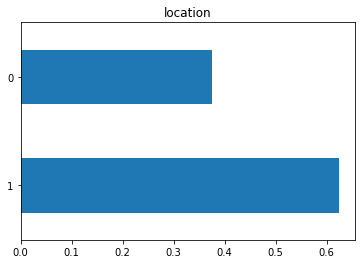

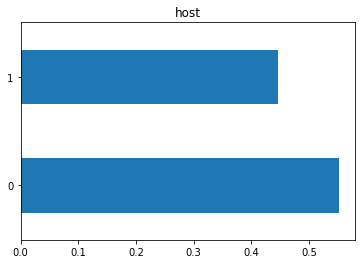

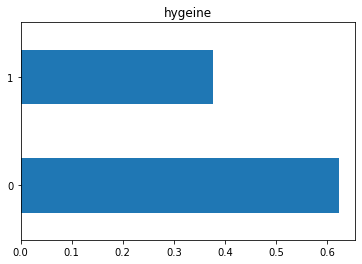

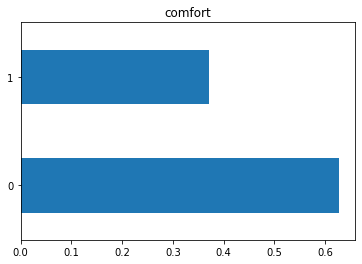

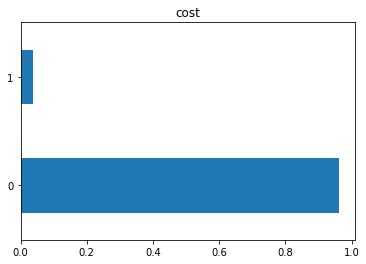

In [ ]:
features = ['location', 'host', 'hygeine', 'comfort', 'cost']

for x in features:
  df[x].value_counts(normalize=True).plot.barh(title=x)
  plt.show()

# Build multiple binary classification models to detect each category within comments. Combine together to form models to detect within comments

In [ ]:
#function to prepare data for modeling

def model_data (target, model_type):
  #prepare dataframes
  X = df['comments']
  y = df[target]

  cvec = CountVectorizer()
  
  #train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

  #vectorize
  X_train_vectorized = cvec.fit_transform(X_train)
  X_test_vectorized = cvec.transform(X_test)
  X_traindf = pd.DataFrame(X_train_vectorized.todense(), columns=cvec.get_feature_names_out())
  X_testdf = pd.DataFrame(X_test_vectorized.todense(), columns=cvec.get_feature_names_out())

  #model fitting
  model = model_type
  model.fit(X_traindf, y_train)

  #predictions
  preds = model.predict(X_testdf)

  #pickle models
  with open('{}.pkl'.format(target), 'wb') as pickle_out:
    pickle_out = pickle.dump(model, pickle_out)

  #scores
  print('----------')
  print(f'{target} accuracy: {model.score(X_traindf, y_train)}, {model.score(X_testdf, y_test)}')
  print(f'{target} recall: {recall_score(y_test, preds)}')
  print(f'{target} precision: {precision_score(y_test, preds)}')

  #prepare test set for each data based on vectorizer
  df3 = pd.read_csv('all_reviews_for_vectorizing.csv')
  df3.dropna(inplace=True)
  df4 = df3.sample(frac=0.02, random_state=35) #sample down data with different random state for different subset
  df4['comments'] = df4['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) #remove stop words from dataframe

  #transform test set
  X2 = df4['comments']
  X2_test = cvec.transform(X2.values)
  X2df = pd.DataFrame(X2_test.todense(), columns=cvec.get_feature_names_out())

  #save transformed test set
  X2df.to_csv('{}_test_dataset.csv'.format(target), index=False)

  return 

In [ ]:
#model results for Logistic Regression
for x in features:
  model_data(x, LogisticRegression())

----------
location accuracy: 0.9981186365648517, 0.9767596281540505
location recall: 0.9708067940552016
location precision: 0.9918655097613883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


----------
host accuracy: 0.9965692784417884, 0.9843957503320053
host recall: 0.9680534918276374
host precision: 0.9969395562356542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


----------
hygeine accuracy: 0.997675962815405, 0.9850597609561753
hygeine recall: 0.9611307420494699
hygeine precision: 0.9990817263544536


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


----------
comfort accuracy: 0.9969012837538734, 0.9774236387782205
comfort recall: 0.9446428571428571
comfort precision: 0.9943609022556391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


----------
cost accuracy: 0.9995573262505534, 0.9946879150066401
cost recall: 0.8545454545454545
cost precision: 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


# Modeling Results
- Based on the words discovered during EDA, the logistic model performs fairly well on terms of accuracy, precision and recall. Each category performs above their baseline majority categories.
- The only exception are categorise with a precision rate of 1.0, which means additional data related specifically to cost will need to be brough into the dataset to better train the model.
- Now that models have been created to detect subcategory themes from reviews, the next step will be ensembling these models and applying them to test data.

# Testing Models with Test Data

In [ ]:
#load models
with open('location.pkl', 'rb') as pickle_in:
    loc_model = pickle.load(pickle_in)

with open('host.pkl', 'rb') as pickle_in:
    host_model = pickle.load(pickle_in)

with open('hygeine.pkl', 'rb') as pickle_in:
    hygeine_model = pickle.load(pickle_in)

with open('comfort.pkl', 'rb') as pickle_in:
    comfort_model = pickle.load(pickle_in)

with open('cost.pkl', 'rb') as pickle_in:
    cost_model = pickle.load(pickle_in)

In [ ]:
#load test dataset
locdf = pd.read_csv('location_test_dataset.csv')
hostdf = pd.read_csv('host_test_dataset.csv')
hygeinedf = pd.read_csv('hygeine_test_dataset.csv')
comfortdf = pd.read_csv('comfort_test_dataset.csv')
costdf = pd.read_csv('cost_test_dataset.csv')

In [ ]:
#join prediction results to original data for comparison
test_df = pd.read_csv('all_reviews_for_vectorizing.csv')
test_df.dropna(inplace=True)
test_df2 = test_df.sample(frac=0.02, random_state=35)
test_df2['comments'] = test_df2['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df2 = test_df2[['comments']]

#joining predictions to test dataframe
test_df2['location_predictions'] = loc_model.predict(locdf)
test_df2['host_predictions'] = host_model.predict(hostdf)
test_df2['hygeine_predictions'] = hygeine_model.predict(hygeinedf)
test_df2['comfort_predictions'] = comfort_model.predict(comfortdf)
test_df2['cost_predictions'] = cost_model.predict(costdf)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
test_df2.head(3)

,comments,location_predictions,host_predictions,hygeine_predictions,comfort_predictions,cost_predictions
26735,lulia worked home arrived flexible early depar...,0,0,1,0,1
475965,great sam accommodating responds super fast me...,1,0,0,0,0
447766,great value short walk train edgar accommodati...,0,0,0,0,1


In [ ]:
#export test results to csv
test_df2.to_csv('model_results.csv', index=False)